## Set up

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import ks_2samp

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

drivepath = '/content/drive/MyDrive/ELP Term D - Mortgage Loss Severity/Datasets and Guides/'

In [ ]:
df = pd.read_parquet(f'{drivepath}/gse_model_data_merged.parquet')
df = df[(df['Loss Rate'] > df['Loss Rate'].quantile(.001)) & (df['Loss Rate'] < df['Loss Rate'].quantile(.999))]
df = df[df['dur_def_episode']>0].copy()
#df =  df[(df['Original Loan-to-Value (LTV)'] >= 47) & (df['Original Loan-to-Value (LTV)'] <= 100)]

In [ ]:
df.loc[:,'TPS'] = 0
df.loc[:,'SS'] = 0
df.loc[:,'REO'] = 0

df.loc[df['Zero Balance Code']==2,'TPS'] = 1
df.loc[df['Zero Balance Code']==3,'SS'] = 1
df.loc[df['Zero Balance Code']==9,'REO'] = 1

In [ ]:
df['creditscore'] = ((df['Credit Score'] - df['Credit Score'].mean())/df['Credit Score'].std())

In [ ]:
df = df.drop(df.filter(regex='SCORE.1').columns,axis=1)

In [ ]:
## Rename Variables
mapper = {
    'Loan Age': 'loan_age',
    'Credit Score': 'fico'
}

df.rename(mapper, axis=1, inplace=True)

## Drop cltv_current = null, hpat2y = null
df = df[df.cltv_current.notnull() & df.hpat2y.notnull()]
df.loc[:, 'fico_missing'] = df.fico.isnull().astype(int)
df.loc[df.fico.isnull(), 'fico'] = df.fico.mean()


In [ ]:
# Remove .1% outliers
df1 = df[
    (df['Loss Rate'] > df['Loss Rate'].quantile(.001)) &
    (df['Loss Rate'] < df['Loss Rate'].quantile(.999))
]

df1.loc[:, 'Loss Rate'] = df1['Loss Rate'] * 100

# Implemented from Cordell paper
df1 =  df1[(df1['Original Loan-to-Value (LTV)'] <= 100)]

df1 = df1[df1.fico_missing == 0]
df1 = df1[df1['Original Debt-to-Income (DTI) Ratio'].notnull()]
df1.loc[:, 'Pre2005'] = df1.orig_year.apply(lambda x: 1 if x < 2005 else 0)
df1.loc[:, 'Log Original UPB'] = df['Original UPB'].apply(lambda x: np.log(x))

# Set Channel Dummies (B = 3rd party broker)
df1 =  df1.join(pd.get_dummies(df1['Channel'], prefix='channel', drop_first=True))
df1.channel_C = df1.channel_C.astype(int)
df1.channel_R = df1.channel_R.astype(int)

# Set Loan Purpose Dummies (R = Refinance unknown purpose)
df1.loc[:, 'loanpurpose_N'] = (df1['Loan Purpose'] == 'N').astype(int)
df1.loc[:, 'loanpurpose_P'] = (df1['Loan Purpose'] == 'P').astype(int)
df1.loc[:, 'loanpurpose_C'] = (df1['Loan Purpose'] == 'C').astype(int)

df1 = df1[df1.RISK_VALUE.notnull()]

# Log of climate variables
df1.loc[:, 'LogRISK_VALUE'] = df1.RISK_VALUE.apply(lambda x: np.log(x))
df1.loc[:, 'LogEAL_VALT'] = df1.EAL_VALT.apply(lambda x: np.log(x))

def middle_spline(x, k1, k2):
  if x <= k1: return 0
  elif k1 <= x <= k2: return x - k1
  else: return k2 - k1

In [ ]:
# Splining
cltv_k1 = 80
cltv_k2 = 120
df1['cltv_current1'] = np.minimum(df1.cltv_current, cltv_k1)
df1['cltv_current2'] = df1.cltv_current.apply(lambda x: middle_spline(x, cltv_k1, cltv_k2))
df1['cltv_current3'] = np.maximum(df1.cltv_current - cltv_k2, 0)

fico_k1 = 620
fico_k2 = 750
df1['fico1'] = np.minimum(df1.fico, fico_k1)
df1['fico2'] = df1.fico.apply(lambda x: middle_spline(x, fico_k1, fico_k2))
df1['fico3'] = np.maximum(df1.fico - fico_k2, 0)

exog = [
    'channel_C',
    'channel_R',
    'Boom',
    'Bust',
    'PostCrisis',
    'loanpurpose_N',
    'loanpurpose_P',
    'loanpurpose_C',
]

## Some statistics

In [ ]:
df['buckets']=df[['normal','boom','crisis','bust','post']].idxmax(axis=1)

In [ ]:
df['Zero Balance Code'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Zero Balance Code
9    67.9%
3    20.1%
2    12.0%
Name: proportion, dtype: object

In [ ]:
df1[['cltv_current','appreciation_factor','EAL_SCORE','Original Loan-to-Value (LTV)']].corr()

,cltv_current,appreciation_factor,EAL_SCORE,Original Loan-to-Value (LTV)
cltv_current,1.000000,-0.811345,0.306555,0.302078
appreciation_factor,-0.811345,1.000000,-0.345484,0.134174
EAL_SCORE,0.306555,-0.345484,1.000000,-0.103137
Original Loan-to-Value (LTV),0.302078,0.134174,-0.103137,1.000000


<Axes: xlabel='Zero Balance Code'>

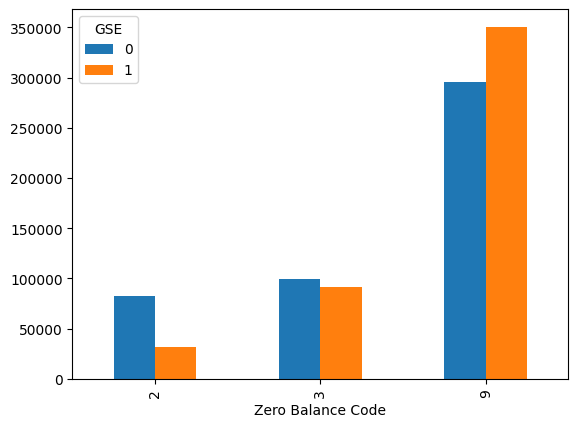

In [ ]:
grouped = df.groupby(['Zero Balance Code', 'GSE']).size().unstack(fill_value=0)

# Plotting the bar graph
grouped.plot(kind='bar')


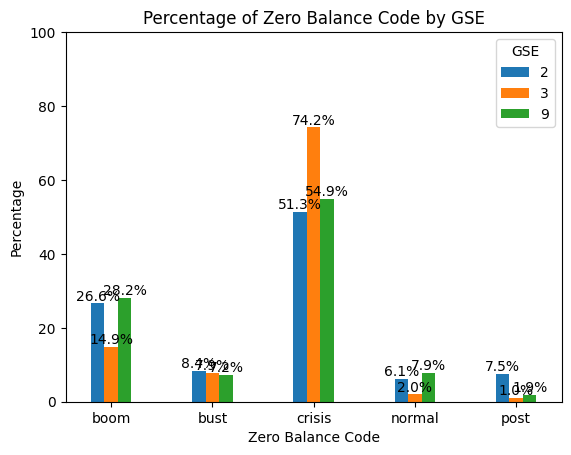

In [ ]:
grouped = df.groupby(['buckets','Zero Balance Code']).size().unstack(fill_value=0)

# Calculating the total count of each GSE value across all Zero Balance Codes
total_counts = grouped.sum(axis=0)

# Calculating the percentage for each GSE value based on the total count of each GSE value
grouped_percentage = grouped.div(total_counts, axis=1) * 100

# Plotting the bar graph
ax = grouped_percentage.plot(kind='bar', width=0.4)

# Customizing the plot
plt.xlabel('Zero Balance Code')
plt.ylabel('Percentage')
plt.title('Percentage of Zero Balance Code by GSE')
plt.legend(title='GSE')
plt.ylim(0, 100)  # Setting y-axis limit to 0-100%

# Adjusting x-axis tick labels
ax.set_xticklabels(grouped_percentage.index, rotation=0)

# Adding percentage labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

plt.show()

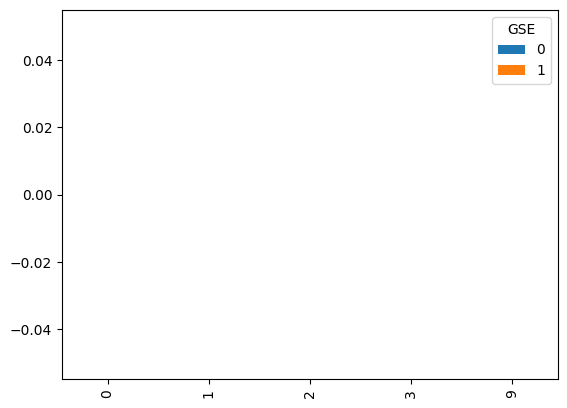

In [ ]:
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plotting the bar graph
ax = grouped_percentage.plot(kind='bar', width=0.4)


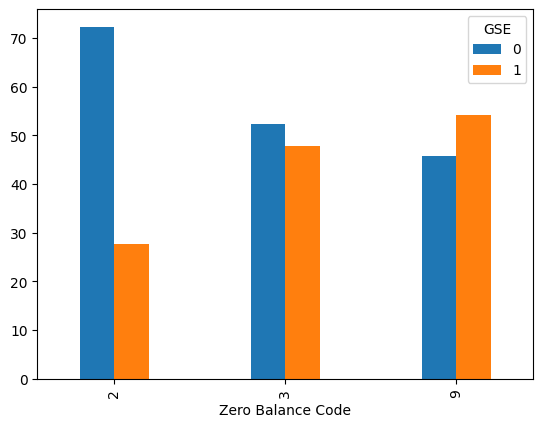

In [ ]:
total_counts = grouped.sum(axis=1)

# Converting counts to percentages based on the total count of each Zero Balance Code
grouped_percentage = grouped.div(total_counts, axis=0) * 100

# Plotting the bar graph
ax = grouped_percentage.plot(kind='bar', width=0.4)

In [ ]:
df[['Zero Balance Code','GSE']]

,Zero Balance Code,GSE
0,3,0
1,9,0
2,9,0
3,9,0
4,9,0
...,...,...
954506,9,1
954507,3,1
954508,9,1
954509,9,1


In [ ]:
df['stupid'] = 1

<Axes: xlabel='Zero Balance Code', ylabel='stupid'>

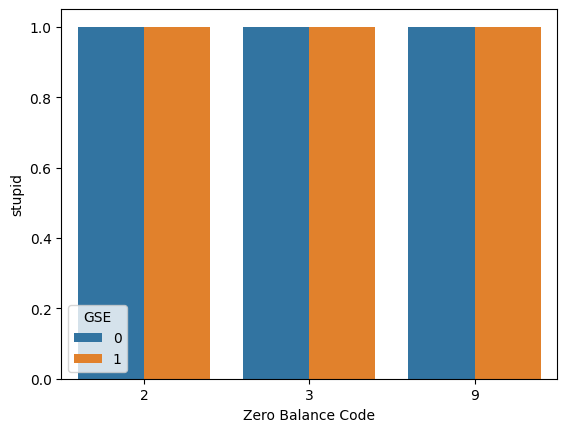

In [ ]:
sns.barplot(df,x='Zero Balance Code', y='stupid',hue='GSE')

In [ ]:
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
df1.groupby('GSE')[['REO','TPS','SS']].mean()*100

,REO,TPS,SS
GSE,,,
0,61.897139,17.215410,20.887451
1,73.853101,6.776373,19.370526


In [ ]:
df1.groupby('GSE')[['REO','TPS','SS']].sum()

,REO,TPS,SS
GSE,,,
0,286507,79686,96683
1,331209,30390,86871


In [ ]:
df1[['REO','TPS','SS']].sum()

REO    617716
TPS    110076
SS     183554
dtype: int64

In [ ]:
df1.count()

Loan Sequence Number                                            911346
Modification Flag                                                63405
Metropolitan Statistical Area (MSA) Or Metropolitan Division    911346
loan_age                                                        911346
Prepayment Penalty Mortgage (PPM) Flag                          911344
                                                                 ...  
cltv_current2                                                   911346
cltv_current3                                                   911346
fico1                                                           911346
fico2                                                           911346
fico3                                                           911346
Length: 243, dtype: int64

In [ ]:
df1.groupby('orig_year')[['REO','TPS','SS']].mean()*100

,REO,TPS,SS
orig_year,,,
1999,71.45,23.11,5.44
2000,85.45,9.28,5.27
2001,83.68,9.71,6.61
2002,81.37,10.86,7.77
2003,75.30,13.49,11.21
2004,71.74,12.73,15.53
2005,63.76,12.18,24.06
2006,63.53,10.46,26.01
2007,64.15,9.84,26.02


## Helper functions

In [ ]:
def plot_roc_auc(y_true,y_pred,x=False):
  # Compute ROC curve and ROC area for each class
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)*100
  print(f"The area under curve is {roc_auc:0.2f}%")
  if(x):
    # Plot ROC curves
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
  return

In [ ]:
def evaluate_ks(y_true,y_pred):
  # Unite both visions to be able to filter
  df = pd.DataFrame()
  df['true'] = y_true
  df['pred'] = y_pred

  class0 = df[df['true'] == 0]
  class1 = df[df['true'] == 1]

  ks = ks_2samp(class0['pred'], class1['pred'])

  print(f"KS between class1 and others: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
  return

In [ ]:
def printres(Res1,x=False):
  plot_roc_auc(Res1[2],Res1[4],x)
  plot_roc_auc(Res1[3],Res1[5],x)
  evaluate_ks(Res1[2],Res1[4])
  evaluate_ks(Res1[3],Res1[5])

In [ ]:
def Runnestedlogit(varlist,varlist2,df):
  df2 = df[varlist]
  df2 = df2.dropna()
  TPS = df2.pop('TPS')
  REO = df2.pop('REO')
  SS  = df2.pop('SS')

  df3  = df[varlist2]
  df3  = df3.dropna()
  TPS  = df3.pop('TPS')
  REO  = df3.pop('REO')
  SS2  = df3.pop('SS')
  REO2 = REO[SS==0]
  TPS2 = TPS[SS==0]
  df3  = df3[SS==0]

  SSlogit = sm.Logit(SS, sm.add_constant(df2)).fit()
  #print(TPSlogit.summary())
  SSlogit_pred = SSlogit.predict(sm.add_constant(df2))


  TPS2logit = sm.Logit(TPS2, sm.add_constant(df3)).fit()
  #print(REO2logit.summary())
  TPS2logit_pred = TPS2logit.predict(sm.add_constant(df3))

  return SSlogit,TPS2logit,SS,TPS2,SSlogit_pred,TPS2logit_pred

WHERE WE BELIEVE CLIMATE HAS EFFECT ON PROBABILITY AND LOSS. WE BELIEVE FURTHER H. WE RECOMMEND THAT THE FHFA PROVIDE MORE GRANULAR DATA FOR GSE. WE FIND THERE IS A GSE EFFECT THIS COULD BE DUE TO ISUUES RELATED TO THE PROCESSESS USED TO DETEREMINE

SO WHATS
DISSASTER DECLARTION IS ALSO SIGNIFICANT MORE INVEST NEEEDED BUT

BY UNDERSTANDING THE EMPERICAL IMPACT OF NATURAL DISASTERSS ON LOSS WILL HELP FANNIE AND FREDDIE

# Hide

## Experiments


In [ ]:
var1 = ['cltv_current',
    'loansize',
    'hpat2y',
    'dur_def_episode',
    'mr_sprd',
    'judicial',
    'deficiency',
    'refinance',
    'flag_24',
    'noowner_occ',
    'proptype_CP',
    'proptype_MH',
    'proptype_PU',
    'proptype_SF',
    'REO',
    'TPS',
    'SS'
]
Res1 = Runnestedlogit(var1,var1,df1)

Optimization terminated successfully.
         Current function value: 0.345723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451507
         Iterations 7


In [ ]:
printres(Res1)

0.6781313999042781
0.775275038154926
KS between class1 and others: 0.2740 (p-value: 0.000e+00)
KS between class1 and others: 0.4344 (p-value: 0.000e+00)


In [ ]:
var1 = ['cltv_current2',
    'cltv_current3',
    'fico2',
    'fico3',
    'loansize',
    'hpat2y',
    'dur_def_episode',
    'mr_sprd',
    'judicial',
    'deficiency',
    'refinance',
    'flag_24',
    'noowner_occ',
    'proptype_CP',
    'proptype_MH',
    'proptype_PU',
    'proptype_SF',
    'REO',
    'TPS',
    'SS'
]
Res1 = Runnestedlogit(var1,var1,df1)

Optimization terminated successfully.
         Current function value: 0.343819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445498
         Iterations 7


In [ ]:
printres(Res1)

0.6873989585760109
0.7796952818374072
KS between class1 and others: 0.2824 (p-value: 0.000e+00)
KS between class1 and others: 0.4362 (p-value: 0.000e+00)


In [ ]:
print(Res1[0].summary())

                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               914867
Model:                          Logit   Df Residuals:                   914849
Method:                           MLE   Df Model:                           17
Date:                Mon, 06 May 2024   Pseudo R-squ.:                 0.06655
Time:                        20:50:58   Log-Likelihood:            -3.1455e+05
converged:                       True   LL-Null:                   -3.3697e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.0606      0.036   -168.839      0.000      -6.131      -5.990
cltv_current2      -0.0210      0.000    -71.710      0.000      -0.022      -0.020
cltv_current3       0.0193      

In [ ]:
print(Res1[1].summary())

                           Logit Regression Results                           
Dep. Variable:                    REO   No. Observations:               804436
Model:                          Logit   Df Residuals:                   804418
Method:                           MLE   Df Model:                           17
Date:                Mon, 06 May 2024   Pseudo R-squ.:                  0.1716
Time:                        20:53:28   Log-Likelihood:            -3.5837e+05
converged:                       True   LL-Null:                   -4.3260e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.6683      0.031    118.932      0.000       3.608       3.729
cltv_current2      -0.0404      0.000   -165.311      0.000      -0.041      -0.040
cltv_current3      -0.0084      

In [ ]:
exog = [
    'cltv_current2',
    'cltv_current3',
    'loansize',
    'hpat2y',
    'loan_age',
    'dur_def_episode',
    #'fico1',
    'fico2',
    'fico3',
    'mr_sprd',
    'judicial',
    'deficiency',
    # 'refinance',
    'flag_24',
    'noowner_occ',
    'proptype_CP',
    'proptype_MH',
    'proptype_PU',
    'proptype_SF',
    'GSE',
    'prior_mod',
    'Log Original UPB',
    #'Pre2005',
    'channel_C',
    'channel_R',
    # 'Zero Balance Removal UPB',
    'Normal',
    'Boom',
    'Bust',
    'PostCrisis',
    'appreciation_factor',
    'loanpurpose_N',
    'loanpurpose_P',
    'loanpurpose_C',
    'TPS',
    'SS',
    'REO'
]

In [ ]:
Res2 = Runnestedlogit(exog,exog,df1)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.326090
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.431914
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
printres(Res2)

0.7440833499109785
0.7995597488830891
KS between class1 and others: 0.3605 (p-value: 0.000e+00)
KS between class1 and others: 0.4681 (p-value: 0.000e+00)


In [ ]:
v2 = ['cltv_current',
  'GSE',
  'boom',
  'crisis',
  'bust',
  'post',
  'Current Interest Rate',
  'appreciation_factor',
  'hpat2y',
  'dur_def_episode',
  'creditscore',
  'Loan Age',
  'judicial',
  'deficiency',
  'refinance',
  'flag_24',
  'noowner_occ',
  'proptype_CP',
  'proptype_MH',
  'proptype_PU',
  'proptype_SF',
  'log_UPB',
  'TPS',
  'SS',
  'REO'
          ]

In [ ]:
Res2 = Runnestedlogit(v2,v2,df)
printres(Res2)
print(Res2[0].summary())

Optimization terminated successfully.
         Current function value: 0.324414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415464
         Iterations 7


In [ ]:
v3 = ['cltv_current',
  'GSE',
  'boom',
  'crisis',
  'bust',
  'post',
  'Current Interest Rate',
  'RISK_SCORE',
  'hpat2y',
  'dur_def_episode',
  'creditscore',
  'Loan Age',
  'judicial',
  'deficiency',
  'refinance',
  'flag_24',
  'noowner_occ',
  'proptype_CP',
  'proptype_MH',
  'proptype_PU',
  'proptype_SF',
  'log_UPB',
  'TPS',
  'SS',
  'REO'
          ]

In [ ]:
Res3 = Runnestedlogit(v3,v3,df)
printres(Res3)
print(Res3[0].summary())

Optimization terminated successfully.
         Current function value: 0.321863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413496
         Iterations 7
0.7513375971529836
0.817421130731751
KS between class1 and others: 0.3705 (p-value: 0.000e+00)
KS between class1 and others: 0.4933 (p-value: 0.000e+00)
                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               939634
Model:                          Logit   Df Residuals:                   939611
Method:                           MLE   Df Model:                           22
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.1263
Time:                        16:18:02   Log-Likelihood:            -3.0243e+05
converged:                       True   LL-Null:                   -3.4616e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
           

In [ ]:
Res4 = Runnestedlogit(v2+['RISK_SCORE'],v2+['RISK_SCORE'],df)
printres(Res4)
print(Res4[0].summary())

Optimization terminated successfully.
         Current function value: 0.321462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410071
         Iterations 7
0.7520562109793015
0.8217133213328653
KS between class1 and others: 0.3700 (p-value: 0.000e+00)
KS between class1 and others: 0.5005 (p-value: 0.000e+00)
                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               939634
Model:                          Logit   Df Residuals:                   939610
Method:                           MLE   Df Model:                           23
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.1274
Time:                        16:21:51   Log-Likelihood:            -3.0206e+05
converged:                       True   LL-Null:                   -3.4616e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
          

In [ ]:
df['appreciation_factor'].corr(df['RISK_SCORE'])

-0.34499876709930044

In [ ]:
v4 = ['cltv_current2',
    'cltv_current3',
    'fico2',
    'fico3',
  'GSE',
  'boom',
  'crisis',
  'bust',
  'post',
  'Current Interest Rate',
  'appreciation_factor',
  'hpat2y',
  'dur_def_episode',
  'loan_age',
  'judicial',
  'deficiency',
  'refinance',
  'flag_24',
  'noowner_occ',
  'proptype_CP',
  'proptype_MH',
  'proptype_PU',
  'proptype_SF',
  'log_UPB',
  'TPS',
  'SS',
  'REO',
      ]

In [ ]:
for i in ['EAL_VALT','EAL_SCORE','RISK_VALUE','RISK_SCORE','RISK_RATNG','EAL_RATNG']:
  Resi = Runnestedlogit(v4+[i],v4+[i],df)
  print(i)
  print(Resi[0].params[-1])
  printres(Resi)

Optimization terminated successfully.
         Current function value: 0.308437
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.413546
         Iterations 8
EAL_VALT
3.6166265526861125e-10
0.7779779521841679
0.818695272227675
KS between class1 and others: 0.4170 (p-value: 0.000e+00)
KS between class1 and others: 0.5004 (p-value: 0.000e+00)
Optimization terminated successfully.
         Current function value: 0.307471
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409301
         Iterations 8
EAL_SCORE
0.013737980034928595
0.7788849448547102
0.8228713597393292
KS between class1 and others: 0.4201 (p-value: 0.000e+00)
KS between class1 and others: 0.5022 (p-value: 0.000e+00)
Optimization terminated successfully.
         Current function value: 0.308460
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.413623
         Iterations 8
RISK_VALUE
2.65341

In [ ]:
v5 = v4+ list(df.filter(regex='_RISK_SCORE').columns)

In [ ]:
Resi = Runnestedlogit(v5,v5,df1)
printres(Resi)

Optimization terminated successfully.
         Current function value: 0.319661
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408591
         Iterations 7
0.7580999991667712
0.822805575887162
KS between class1 and others: 0.3823 (p-value: 0.000e+00)
KS between class1 and others: 0.5024 (p-value: 0.000e+00)


In [ ]:
Resi = Runnestedlogit(v5,v5,df)
printres(Resi)

Optimization terminated successfully.
         Current function value: 0.321141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409702
         Iterations 7
0.753037722137174
0.8220992545297232
KS between class1 and others: 0.3715 (p-value: 0.000e+00)
KS between class1 and others: 0.5008 (p-value: 0.000e+00)


In [ ]:
print(Resi[0].summary())

                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               939634
Model:                          Logit   Df Residuals:                   939602
Method:                           MLE   Df Model:                           31
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.1283
Time:                        17:00:09   Log-Likelihood:            -3.0175e+05
converged:                       True   LL-Null:                   -3.4616e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.8835      0.102    -57.488      0.000      -6.084      -5.683
cltv_current             -0.0065      0.000    -28.457      0.000      -0.007      -0.006
GSE     

In [ ]:
print(Resi[0].summary())

                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               914867
Model:                          Logit   Df Residuals:                   914833
Method:                           MLE   Df Model:                           33
Date:                Mon, 06 May 2024   Pseudo R-squ.:                  0.1321
Time:                        21:11:33   Log-Likelihood:            -2.9245e+05
converged:                       True   LL-Null:                   -3.3697e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.5925      0.102    -64.717      0.000      -6.792      -6.393
cltv_current2            -0.0103      0.000    -26.270      0.000      -0.011      -0.010
cltv_cur

In [ ]:
v4

['cltv_current',
 'GSE',
 'boom',
 'crisis',
 'bust',
 'post',
 'Current Interest Rate',
 'appreciation_factor',
 'hpat2y',
 'dur_def_episode',
 'creditscore',
 'Loan Age',
 'judicial',
 'deficiency',
 'refinance',
 'flag_24',
 'noowner_occ',
 'proptype_CP',
 'proptype_MH',
 'proptype_PU',
 'proptype_SF',
 'log_UPB',
 'TPS',
 'SS',
 'REO']

In [ ]:
v6 = v4+ list(df.filter(regex='EALS').columns)

In [ ]:
df[df.filter(regex='EALT').columns] = df[df.filter(regex='EALT').columns].fillna(0)

In [ ]:
df.filter(regex='EALS').columns

In [ ]:
Resrr = Runnestedlogit(v6,v6,df)
printres(Resrr)

Optimization terminated successfully.
         Current function value: 0.307848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405508
         Iterations 7
0.7880965367336537
0.825911739711777
KS between class1 and others: 0.4306 (p-value: 0.000e+00)
KS between class1 and others: 0.5083 (p-value: 0.000e+00)


In [ ]:
v7 = v4+ list(df.filter(regex='_RISKR').columns)

In [ ]:
Res = Runnestedlogit(v7,v7,df)
printres(Res)

Optimization terminated successfully.
         Current function value: 0.309570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403988
         Iterations 7
0.786961010191146
0.8275275764681835
KS between class1 and others: 0.4284 (p-value: 0.000e+00)
KS between class1 and others: 0.5115 (p-value: 0.000e+00)


In [ ]:
v8 = v4+ list(df.filter(regex='_EALR').columns)
Res = Runnestedlogit(v8,v8,df)
printres(Res)

NameError: name 'v4' is not defined

In [ ]:
print(Res[0].summary())

                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               935199
Model:                          Logit   Df Residuals:                   935173
Method:                           MLE   Df Model:                           25
Date:                Wed, 01 May 2024   Pseudo R-squ.:                  0.1455
Time:                        04:45:36   Log-Likelihood:            -2.8880e+05
converged:                       True   LL-Null:                   -3.3797e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -278.2452      4.259    -65.336      0.000    -286.592    -269.898
cltv_current                     0.0187      0.000     68.360      0.000     

In [ ]:
print(Resrr[0].summary())

                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               928528
Model:                          Logit   Df Residuals:                   928484
Method:                           MLE   Df Model:                           43
Date:                Wed, 01 May 2024   Pseudo R-squ.:                  0.1761
Time:                        04:30:24   Log-Likelihood:            -2.7743e+05
converged:                       True   LL-Null:                   -3.3671e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -287.6556      4.352    -66.096      0.000    -296.185    -279.126
cltv_current                     0.0102      0.000     33.554      0.000     

In [ ]:
print(Resrr[1].summary())

                           Logit Regression Results                           
Dep. Variable:                    REO   No. Observations:               826184
Model:                          Logit   Df Residuals:                   826140
Method:                           MLE   Df Model:                           43
Date:                Wed, 01 May 2024   Pseudo R-squ.:                  0.2504
Time:                        14:43:00   Log-Likelihood:            -3.3320e+05
converged:                       True   LL-Null:                   -4.4452e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          142.8336      5.107     27.967      0.000     132.824     152.843
cltv_current                    -0.0049      0.000    -16.149      0.000     

In [ ]:
(df.filter(regex='RISKR')!=0).mean()

AVLN_RISKR    0.103397
CFLD_RISKR    0.378909
CWAV_RISKR    0.708679
DRGT_RISKR    0.832756
ERQK_RISKR    0.999927
HAIL_RISKR    0.999923
HWAV_RISKR    0.807814
HRCN_RISKR    0.778898
ISTM_RISKR    0.718502
LNDS_RISKR    0.999167
LTNG_RISKR    0.997929
RFLD_RISKR    0.999969
SWND_RISKR    0.999167
TRND_RISKR    0.999999
TSUN_RISKR    0.060590
VLCN_RISKR    0.050986
WFIR_RISKR    0.999999
WNTW_RISKR    0.886882
dtype: float64

In [ ]:
(df.filter(regex='RISKR')==0).mean()

AVLN_RISKR    0.896603
CFLD_RISKR    0.621091
CWAV_RISKR    0.291321
DRGT_RISKR    0.167244
ERQK_RISKR    0.000073
HAIL_RISKR    0.000077
HWAV_RISKR    0.192186
HRCN_RISKR    0.221102
ISTM_RISKR    0.281498
LNDS_RISKR    0.000833
LTNG_RISKR    0.002071
RFLD_RISKR    0.000031
SWND_RISKR    0.000833
TRND_RISKR    0.000001
TSUN_RISKR    0.939410
VLCN_RISKR    0.949014
WFIR_RISKR    0.000001
WNTW_RISKR    0.113118
dtype: float64

In [ ]:
(df.filter(regex='RISKR')>=3).mean()

AVLN_RISKR    0.019942
CFLD_RISKR    0.077895
CWAV_RISKR    0.517088
DRGT_RISKR    0.250007
ERQK_RISKR    0.272996
HAIL_RISKR    0.274234
HWAV_RISKR    0.571779
HRCN_RISKR    0.255432
ISTM_RISKR    0.497202
LNDS_RISKR    0.635762
LTNG_RISKR    0.743646
RFLD_RISKR    0.590349
SWND_RISKR    0.600548
TRND_RISKR    0.681358
TSUN_RISKR    0.016773
VLCN_RISKR    0.020782
WFIR_RISKR    0.361073
WNTW_RISKR    0.492505
dtype: float64

In [ ]:
df['AVLN_RISKR']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
954506    0.0
954507    0.0
954508    0.0
954509    0.0
954510    0.0
Name: AVLN_RISKR, Length: 950102, dtype: float64

In [ ]:
(df.filter(regex='RISKR')>=3).sum()

AVLN_RISKR     18947
CFLD_RISKR     74008
CWAV_RISKR    491286
DRGT_RISKR    237532
ERQK_RISKR    259374
HAIL_RISKR    260550
HWAV_RISKR    543248
HRCN_RISKR    242686
ISTM_RISKR    472393
LNDS_RISKR    604039
LTNG_RISKR    706540
RFLD_RISKR    560892
SWND_RISKR    570582
TRND_RISKR    647360
TSUN_RISKR     15936
VLCN_RISKR     19745
WFIR_RISKR    343056
WNTW_RISKR    467930
dtype: int64

In [ ]:
(df.filter(regex='RISKR')==0).sum()

AVLN_RISKR    853654
CFLD_RISKR    591509
CWAV_RISKR    277239
DRGT_RISKR    159382
ERQK_RISKR        69
HAIL_RISKR        73
HWAV_RISKR    182834
HRCN_RISKR    210336
ISTM_RISKR    267572
LNDS_RISKR       791
LTNG_RISKR      1968
RFLD_RISKR        29
SWND_RISKR       791
TRND_RISKR         1
TSUN_RISKR    894418
VLCN_RISKR    903534
WFIR_RISKR         1
WNTW_RISKR    107543
dtype: int64

In [ ]:
print(Resrr[1].summary())

                           Logit Regression Results                           
Dep. Variable:                    REO   No. Observations:               819095
Model:                          Logit   Df Residuals:                   819051
Method:                           MLE   Df Model:                           43
Date:                Wed, 01 May 2024   Pseudo R-squ.:                  0.2511
Time:                        04:30:26   Log-Likelihood:            -3.3051e+05
converged:                       True   LL-Null:                   -4.4130e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          146.0288      5.127     28.482      0.000     135.980     156.078
cltv_current                    -0.0048      0.000    -15.513      0.000     

In [ ]:
v5 = ['cltv_current',
  'GSE',
  'boom',
  'crisis',
  'bust',
  'post',
  'Current Interest Rate',
  'hpat2y',
  'dur_def_episode',
  'testing',
  'Loan Age',
  'judicial',
  'deficiency',
  'refinance',
  'flag_24',
  'noowner_occ',
  'proptype_CP',
  'proptype_MH',
  'proptype_PU',
  'proptype_SF',
  'log_ZBR_UPB',
  'log_UPB',
  'TPS',
  'SS',
  'REO',
      ]

## NEW EXPERIMENTS

In [ ]:
# Variables Tyler Yang
# Variables based on Tyler Yang, XGBOOST and OLS Experiments
# Variables with Splines - OUR BASE MODEL
# Variables with Different NRI factors
# FINAL Model

### Tyler Yang

In [ ]:
Base_v = [
    'loansize',
    'mr_sprd',
    'refinance',
    'cltv_current',
    'hpat2y',
    'dur_def_episode',
    'judicial',
    'deficiency',
    'flag_24',
    'noowner_occ',
    'proptype_CP',
    'proptype_MH',
    'proptype_PU',
    'proptype_SF',
    'REO',
    'TPS',
    'SS']

In [ ]:
base_m = Runnestedlogit(Base_v,Base_v,df1)
printres(base_m)

Optimization terminated successfully.
         Current function value: 0.425403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399386
         Iterations 6
The area under curve is 77.20%
The area under curve is 67.22%
KS between class1 and others: 0.4283 (p-value: 0.000e+00)
KS between class1 and others: 0.2597 (p-value: 0.000e+00)


In [ ]:
v2_add = [
  'GSE',
  'Normal',
  'Boom',
  'Bust',
  'PostCrisis',
  'channel_C',
  'channel_R',
  'loanpurpose_N',
  'loanpurpose_P',
  'loanpurpose_C',
  'Current Interest Rate',
  'loan_age',
  'Log Original UPB',
  'fico'
          ]
v2 = Base_v[3:] + v2_add

In [ ]:
base_2 = Runnestedlogit(v2,v2,df1)
printres(base_2)

Optimization terminated successfully.
         Current function value: 0.402237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367773
         Iterations 7
The area under curve is 80.09%
The area under curve is 75.67%
KS between class1 and others: 0.4691 (p-value: 0.000e+00)
KS between class1 and others: 0.3859 (p-value: 0.000e+00)


In [ ]:
v3_add = ['cltv_current1','cltv_current2','cltv_current3','fico1','fico2','fico3']
v3 = v3_add + v2[1:-1]

In [ ]:
print(base_2[0].summary())

                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               911346
Model:                          Logit   Df Residuals:                   911323
Method:                           MLE   Df Model:                           22
Date:                Tue, 07 May 2024   Pseudo R-squ.:                  0.1163
Time:                        21:29:20   Log-Likelihood:            -2.9676e+05
converged:                       True   LL-Null:                   -3.3582e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.5711      0.101    -55.369      0.000      -5.768      -5.374
cltv_current             -0.0058      0.000    -24.631      0.000      -0.006      -0.005
hpat2y  

In [ ]:
base_3[0].params

const                   -3.149157
cltv_current1           -0.052851
cltv_current2           -0.009292
cltv_current3            0.011004
fico1                    0.001563
fico2                    0.000720
fico3                   -0.000788
hpat2y                   1.731722
dur_def_episode         -0.013298
judicial                -0.187702
deficiency               0.374805
flag_24                 -0.001517
noowner_occ             -0.087651
proptype_CP             -0.484697
proptype_MH             -0.552782
proptype_PU              0.108318
proptype_SF             -0.137712
GSE                     -1.479263
Normal                  -0.308822
Boom                    -0.035521
Bust                     0.234237
PostCrisis               1.410042
channel_C                0.163857
channel_R                0.214064
loanpurpose_N            0.041220
loanpurpose_P            0.106484
loanpurpose_C            0.093602
Current Interest Rate   -0.160799
appreciation_factor     -0.439166
loan_age      

In [ ]:
x0 = ['EAL_VALT','EAL_SCORE','RISK_VALUE','RISK_SCORE','RISK_RATNG','EAL_RATNG']
x1 = [df1.filter(regex='RISKR').columns[((df1.filter(regex='RISKR')>=3).mean()>0.3)]]
x2 = [df1.filter(regex='EALR').columns[((df1.filter(regex='EALR')>=3).mean()>0.3)]]
x3 = [df1.filter(regex='_RISK_SCORE').columns]
x4 = [df1.filter(regex='EALS').columns[df1.filter(regex='EALS').isna().mean()<0.1]]
x5 = [df1.filter(regex='RISKS').columns[df1.filter(regex='RISKS').isna().mean()<0.1]]
xx = x0+x1+x2+x3+x4+x5

In [ ]:
for i in xx:
  if(type(i)==type('hi')):
    Resi = Runnestedlogit(v3+[i],v3+[i],df1)
    print(i)
    print(Resi[0].params[-1])
  else:
    Resi = Runnestedlogit(v3+list(i),v3+list(i),df1)
    print(i[0])
    print(Resi[0].params[-1])
  printres(Resi)

Optimization terminated successfully.
         Current function value: 0.315082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412994
         Iterations 7
EAL_VALT
3.7551310501125194e-10
The area under curve is 77.01%
The area under curve is 81.85%
KS between class1 and others: 0.3998 (p-value: 0.000e+00)
KS between class1 and others: 0.4994 (p-value: 0.000e+00)
Optimization terminated successfully.
         Current function value: 0.314002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408759
         Iterations 7
EAL_SCORE
0.014184506400477406
The area under curve is 77.09%
The area under curve is 82.27%
KS between class1 and others: 0.4019 (p-value: 0.000e+00)
KS between class1 and others: 0.5026 (p-value: 0.000e+00)
Optimization terminated successfully.
         Current function value: 0.315112
         Iterations 7
Optimization terminated successfully.
         Current function value: 

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# for i in xx[9:]:
#   if(type(i)==type('hi')):
#     Resi = Runnestedlogit(v3+[i],v3+[i],df1)
#     print(i)
#     print(Resi[0].params[-1])
#   else:
#     Resi = Runnestedlogit(v3+list(i),v3+list(i),df1)
#     print(i[0])
#     print(Resi[0].params[-1])
#   printres(Resi)

Optimization terminated successfully.
         Current function value: 0.304982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407406
         Iterations 7
CWAV_EALS
-0.005367346877962706
The area under curve is 79.51%
The area under curve is 82.39%
KS between class1 and others: 0.4373 (p-value: 0.000e+00)
KS between class1 and others: 0.5065 (p-value: 0.000e+00)
Optimization terminated successfully.
         Current function value: 0.305184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407713
         Iterations 7
CWAV_RISKS
-0.005171069526805988
The area under curve is 79.48%
The area under curve is 82.35%
KS between class1 and others: 0.4370 (p-value: 0.000e+00)
KS between class1 and others: 0.5057 (p-value: 0.000e+00)


In [ ]:
Res_nri = Runnestedlogit(v3+list(xx[9]),v3+list(xx[9]),df1)
print(Res_nri[0].params)

Optimization terminated successfully.
         Current function value: 0.304982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407406
         Iterations 7
const                   -3.038617
cltv_current1           -0.044934
cltv_current2           -0.013697
cltv_current3            0.006829
fico1                    0.001351
fico2                    0.000503
fico3                   -0.001341
hpat2y                   1.624137
dur_def_episode         -0.013223
judicial                 0.097419
deficiency               0.236372
refinance               -0.064242
flag_24                  0.022103
noowner_occ             -0.194680
proptype_CP             -0.672636
proptype_MH             -0.672081
proptype_PU              0.157420
proptype_SF             -0.004822
GSE                     -1.540982
boom                     0.375634
crisis                   0.626036
bust                     0.869180
post                     2.147342
Current Intere

In [ ]:
Res_nri[1].params

const                    13.196910
cltv_current1             0.013457
cltv_current2            -0.004208
cltv_current3             0.002326
fico1                     0.000736
fico2                    -0.003064
fico3                    -0.001779
hpat2y                   -1.776697
dur_def_episode           0.095300
judicial                 -1.003304
deficiency                0.190661
flag_24                  -0.239757
noowner_occ              -0.039850
proptype_CP               0.580590
proptype_MH               0.839094
proptype_PU               0.117063
proptype_SF               0.250906
GSE                       0.905518
Normal                    0.026700
Boom                     -0.023663
Bust                     -0.197418
PostCrisis               -0.153041
channel_C                 0.021554
channel_R                 0.051831
loanpurpose_N             0.087194
loanpurpose_P             0.047508
loanpurpose_C             0.118431
Current Interest Rate     0.100698
appreciation_factor 

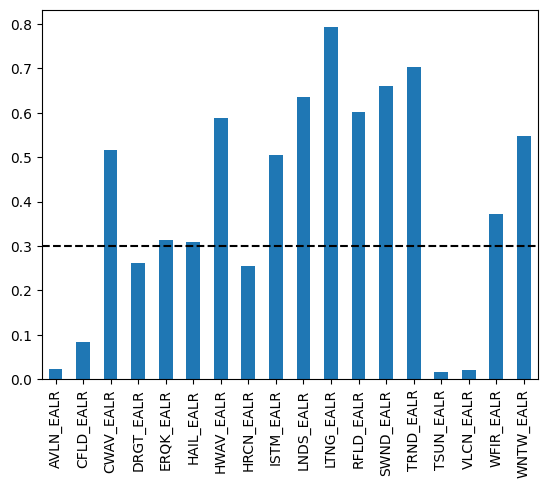

In [ ]:
((df.filter(regex='EALR')>=3).mean()).plot(kind = 'bar')
plt.axhline(y=0.3, color='black', linestyle='--')

# Final

In [ ]:
base_3 = Runnestedlogit(v3,v3,df1)
printres(base_3)

Optimization terminated successfully.
         Current function value: 0.400343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354247
         Iterations 7
The area under curve is 80.34%
The area under curve is 78.22%
KS between class1 and others: 0.4719 (p-value: 0.000e+00)
KS between class1 and others: 0.4258 (p-value: 0.000e+00)


In [ ]:
print(base_3[0].summary())

                           Logit Regression Results                           
Dep. Variable:                     SS   No. Observations:               911346
Model:                          Logit   Df Residuals:                   911316
Method:                           MLE   Df Model:                           29
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.2031
Time:                        17:54:34   Log-Likelihood:            -3.6485e+05
converged:                       True   LL-Null:                   -4.5782e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -15.9485      0.227    -70.116      0.000     -16.394     -15.503
cltv_current1             0.0195      0.001     31.910      0.000       0.018       0.021
cltv_cur

In [ ]:
print(base_3[1].summary())

                           Logit Regression Results                           
Dep. Variable:                    TPS   No. Observations:               727792
Model:                          Logit   Df Residuals:                   727762
Method:                           MLE   Df Model:                           29
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.1662
Time:                        17:54:37   Log-Likelihood:            -2.5782e+05
converged:                       True   LL-Null:                   -3.0921e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.2878      0.237    -26.527      0.000      -6.752      -5.823
cltv_current1            -0.0525      0.000   -122.335      0.000      -0.053      -0.052
cltv_cur

Loanpurpose
Fico, Loanpurpose

In [ ]:
printres(base_3)

The area under curve is 80.34%
The area under curve is 78.22%
KS between class1 and others: 0.4719 (p-value: 0.000e+00)
KS between class1 and others: 0.4258 (p-value: 0.000e+00)


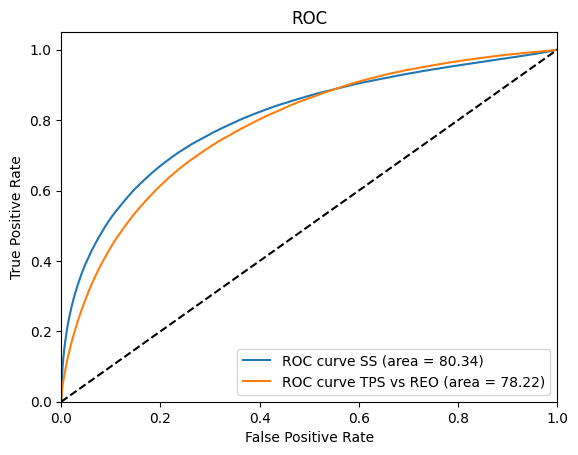

In [ ]:
fpr1, tpr1, _ = roc_curve(base_3[2], base_3[4])
roc_auc1 = auc(fpr1, tpr1)*100

fpr2, tpr2, _ = roc_curve(base_3[3], base_3[5])
roc_auc2 = auc(fpr2, tpr2)*100


plt.figure()
plt.plot(fpr1, tpr1, label=f'ROC curve SS (area = {roc_auc1:0.2f})')
plt.plot(fpr2, tpr2, label=f'ROC curve TPS vs REO (area = {roc_auc2:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Res_nri = Runnestedlogit(v3+list(xx[7]),v3+list(xx[7]),df1)

Optimization terminated successfully.
         Current function value: 0.393758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337019
         Iterations 7


In [ ]:
printres(Res_nri)

The area under curve is 81.12%
The area under curve is 81.37%
KS between class1 and others: 0.4826 (p-value: 0.000e+00)
KS between class1 and others: 0.4768 (p-value: 0.000e+00)


In [ ]:
print(Res_nri[0].summary())

                           Logit Regression Results                           
Dep. Variable:                     SS   No. Observations:               911346
Model:                          Logit   Df Residuals:                   911303
Method:                           MLE   Df Model:                           42
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.2209
Time:                        17:44:33   Log-Likelihood:            -3.5667e+05
converged:                       True   LL-Null:                   -4.5782e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -13.8449      0.237    -58.375      0.000     -14.310     -13.380
cltv_current1             0.0038      0.001      5.815      0.000       0.003       0.005
cltv_cur

Channel

Fico, loanpurpose, SWND, TRND

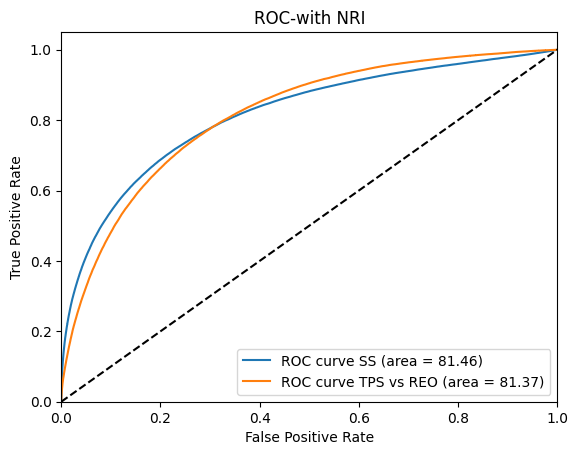

In [ ]:
fpr1, tpr1, _ = roc_curve(Res_nri[2], Res_nri[4])
roc_auc1 = auc(fpr1, tpr1)*100

fpr2, tpr2, _ = roc_curve(Res_nri[3], Res_nri[5])
roc_auc2 = auc(fpr2, tpr2)*100


plt.figure()
plt.plot(fpr1, tpr1, label=f'ROC curve SS (area = {roc_auc1:0.2f})')
plt.plot(fpr2, tpr2, label=f'ROC curve TPS vs REO (area = {roc_auc2:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-with NRI')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Res_nri[0].save('TPS_NRI.pickle')
Res_nri[1].save('REO_NRI.pickle')
base_3[0].save('TPS.pickle')
base_3[1].save('REO.pickle')

In [ ]:
((df1['fico1'] - 600)/11).describe()

count    911346.000000
mean          1.619412
std           1.003399
min         -27.272727
25%           1.818182
50%           1.818182
75%           1.818182
max           1.818182
Name: fico1, dtype: float64

In [ ]:
Res_nri[0].params

const                   -13.844873
cltv_current1             0.003840
cltv_current2             0.006265
cltv_current3            -0.002755
fico1                    -0.000938
fico2                     0.002875
fico3                     0.001885
hpat2y                    1.466818
dur_def_episode          -0.088913
judicial                  0.975141
deficiency               -0.210348
flag_24                   0.228923
noowner_occ               0.059236
proptype_CP              -0.489363
proptype_MH              -0.702229
proptype_PU              -0.150280
proptype_SF              -0.254318
GSE                      -0.540429
Normal                    0.009649
Boom                      0.025341
Bust                      0.179554
PostCrisis               -0.189175
channel_C                -0.019737
channel_R                -0.057915
loanpurpose_N            -0.054323
loanpurpose_P            -0.027592
loanpurpose_C            -0.095153
Current Interest Rate    -0.064387
appreciation_factor 

OPTIMIZED

In [ ]:
vo = v3
print(vo)

['cltv_current1', 'cltv_current2', 'cltv_current3', 'fico1', 'fico2', 'fico3', 'hpat2y', 'dur_def_episode', 'judicial', 'deficiency', 'flag_24', 'noowner_occ', 'proptype_CP', 'proptype_MH', 'proptype_PU', 'proptype_SF', 'REO', 'TPS', 'SS', 'GSE', 'Normal', 'Boom', 'Bust', 'PostCrisis', 'channel_C', 'channel_R', 'loanpurpose_N', 'loanpurpose_P', 'loanpurpose_C', 'Current Interest Rate', 'appreciation_factor', 'loan_age', 'Log Original UPB']


In [ ]:
v4a=['cltv_current1',
 'cltv_current2',
 'cltv_current3',
 'hpat2y',
 'dur_def_episode',
 'judicial',
 'deficiency',
 'flag_24',
 'noowner_occ',
 'proptype_CP',
 'proptype_MH',
 'proptype_PU',
 'proptype_SF',
 'REO',
 'TPS',
 'SS',
 'GSE',
 'Normal',
 'Boom',
 'Bust',
 'PostCrisis',
 'loanpurpose_P',
 'loanpurpose_C',
 'channel_R',
 'Current Interest Rate',
 'appreciation_factor',
 'loan_age',
 'Log Original UPB']

v4b = ['cltv_current1',
 'cltv_current2',
 'cltv_current3',
 'hpat2y',
 'dur_def_episode',
 'judicial',
 'deficiency',
 'flag_24',
 'noowner_occ',
 'proptype_CP',
 'proptype_MH',
 'proptype_PU',
 'proptype_SF',
 'REO',
 'TPS',
 'SS',
 'GSE',
 'Normal',
 'Boom',
 'Bust',
 'PostCrisis',
 'loanpurpose_P',
 'loanpurpose_C',
 'channel_R',
 'Current Interest Rate',
 'appreciation_factor',
 'loan_age',
 'Log Original UPB']

v4c = ['cltv_current1',
 'cltv_current2',
 'cltv_current3',
 'hpat2y',
 'dur_def_episode',
 'judicial',
 'deficiency',
 'flag_24',
 'noowner_occ',
 'proptype_CP',
 'proptype_MH',
 'proptype_PU',
 'proptype_SF',
 'REO',
 'TPS',
 'SS',
 'GSE',
 'Normal',
 'Boom',
 'Bust',
 'PostCrisis',
 'channel_R',
 'loanpurpose_P',
 'loanpurpose_C',
 'Current Interest Rate',
 'loan_age',
 'Log Original UPB']
v4d = ['cltv_current1',
 'cltv_current2',
 'cltv_current3',
 'hpat2y',
 'dur_def_episode',
 'judicial',
 'deficiency',
 'flag_24',
 'noowner_occ',
 'proptype_CP',
 'proptype_MH',
 'proptype_PU',
 'proptype_SF',
 'REO',
 'TPS',
 'SS',
 'GSE',
 'Normal',
 'Boom',
 'Bust',
 'PostCrisis',
 'loanpurpose_P',
 'loanpurpose_C',
 'channel_R',
 'Current Interest Rate',
 'loan_age',
 'Log Original UPB']

In [ ]:
opti1 = Runnestedlogit(v4a,v4b,df1)
printres(opti1)

Optimization terminated successfully.
         Current function value: 0.397511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353890
         Iterations 7
The area under curve is 80.81%
The area under curve is 78.31%
KS between class1 and others: 0.4797 (p-value: 0.000e+00)
KS between class1 and others: 0.4277 (p-value: 0.000e+00)


In [ ]:
opti2 = Runnestedlogit(v4c+list(xx[9]),v4d+list(xx[9]),df1)
printres(opti2)

Optimization terminated successfully.
         Current function value: 0.395100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337108
         Iterations 7
The area under curve is 81.00%
The area under curve is 81.29%
KS between class1 and others: 0.4818 (p-value: 0.000e+00)
KS between class1 and others: 0.4732 (p-value: 0.000e+00)


In [ ]:
print(opti1[0].summary())
print(opti1[1].summary())
print(opti2[0].summary())
print(opti2[1].summary())

                           Logit Regression Results                           
Dep. Variable:                     SS   No. Observations:               911346
Model:                          Logit   Df Residuals:                   911320
Method:                           MLE   Df Model:                           25
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.2087
Time:                        21:36:19   Log-Likelihood:            -3.6227e+05
converged:                       True   LL-Null:                   -4.5782e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -13.3115      0.108   -123.040      0.000     -13.524     -13.099
cltv_current1            -0.0013      0.001     -2.008      0.045      -0.003   -3.09e-05
cltv_cur

In [ ]:
printres(base_3)
printres(Res_nri)

The area under curve is 80.34%
The area under curve is 78.22%
KS between class1 and others: 0.4719 (p-value: 0.000e+00)
KS between class1 and others: 0.4258 (p-value: 0.000e+00)
The area under curve is 81.12%
The area under curve is 81.37%
KS between class1 and others: 0.4826 (p-value: 0.000e+00)
KS between class1 and others: 0.4768 (p-value: 0.000e+00)


In [ ]:
Res_nri[0].params

const                   -16.428316
cltv_current1             0.023142
cltv_current2             0.018657
cltv_current3             0.003437
fico1                    -0.001865
fico2                     0.002777
fico3                     0.002847
hpat2y                    1.036391
dur_def_episode          -0.087722
judicial                  0.915543
deficiency               -0.135222
flag_24                   0.289812
noowner_occ               0.103345
proptype_CP              -0.458073
proptype_MH              -0.696154
proptype_PU              -0.178268
proptype_SF              -0.263791
GSE                      -0.576519
Normal                   -0.162512
Boom                      0.023674
Bust                      0.110543
PostCrisis               -0.522456
channel_C                -0.007379
channel_R                -0.036971
loanpurpose_N            -0.050574
loanpurpose_P            -0.130854
loanpurpose_C            -0.005286
Current Interest Rate    -0.094234
loan_age            

In [ ]:
df1[list(xx[9])+['channel_C','channel_R']].corr()

,CWAV_EALS,DRGT_EALS,ERQK_EALS,HAIL_EALS,HWAV_EALS,LNDS_EALS,LTNG_EALS,RFLD_EALS,SWND_EALS,TRND_EALS,WFIR_EALS,WNTW_EALS,channel_C,channel_R
CWAV_EALS,1.000000,-0.313147,-0.381362,0.141338,-0.164529,-0.139444,0.239520,0.025073,0.419316,0.407225,-0.099180,0.263556,-0.032718,0.013427
DRGT_EALS,-0.313147,1.000000,0.114478,-0.203098,-0.081617,-0.018480,0.050516,0.182694,-0.278440,-0.143118,0.467004,-0.460394,0.047051,-0.026633
ERQK_EALS,-0.381362,0.114478,1.000000,-0.019198,0.400991,0.589233,0.209701,0.427371,-0.014889,0.003348,0.260819,-0.036808,0.051559,-0.057240
HAIL_EALS,0.141338,-0.203098,-0.019198,1.000000,0.238149,0.031337,0.266309,0.123677,0.487151,0.397404,-0.115730,0.403759,0.006856,-0.014339
HWAV_EALS,-0.164529,-0.081617,0.400991,0.238149,1.000000,0.293710,-0.055241,0.258534,0.282866,0.023299,-0.033813,0.422889,0.030573,-0.030171
LNDS_EALS,-0.139444,-0.018480,0.589233,0.031337,0.293710,1.000000,0.223177,0.433905,0.017840,-0.011167,0.259994,0.034318,0.050079,-0.064841
LTNG_EALS,0.239520,0.050516,0.209701,0.266309,-0.055241,0.223177,1.000000,0.524764,0.427150,0.587582,0.306112,0.033825,0.007826,-0.027349
RFLD_EALS,0.025073,0.182694,0.427371,0.123677,0.258534,0.433905,0.524764,1.000000,0.199405,0.308277,0.477386,-0.056558,0.026455,-0.040683
SWND_EALS,0.419316,-0.278440,-0.014889,0.487151,0.282866,0.017840,0.427150,0.199405,1.000000,0.688051,-0.232131,0.528164,-0.022561,0.002576
TRND_EALS,0.407225,-0.143118,0.003348,0.397404,0.023299,-0.011167,0.587582,0.308277,0.688051,1.000000,-0.079103,0.280515,-0.012897,-0.016436


In [ ]:
print(base_3[0].summary())
print(base_3[1].summary())
print(Res_nri[0].summary())
print(Res_nri[1].summary())

                           Logit Regression Results                           
Dep. Variable:                     SS   No. Observations:               911346
Model:                          Logit   Df Residuals:                   911316
Method:                           MLE   Df Model:                           29
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.2031
Time:                        21:28:53   Log-Likelihood:            -3.6485e+05
converged:                       True   LL-Null:                   -4.5782e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -15.9485      0.227    -70.116      0.000     -16.394     -15.503
cltv_current1             0.0195      0.001     31.910      0.000       0.018       0.021
cltv_cur

## Appendix

In [ ]:
np.linalg.matrix_rank(df1[['Normal','Boom','Bust','PostCrisis']])

4

281090.000000


In [ ]:
df1[(df1['Normal']+df1['Boom']+df1['Bust']+df1['PostCrisis'])==0].orig_year.describe()

count    281090.000000
mean       2006.339126
std           1.339820
min        2005.000000
25%        2005.000000
50%        2006.000000
75%        2007.000000
max        2012.000000
Name: orig_year, dtype: float64

In [ ]:
df1[(df1['Normal']+df1['Boom']+df1['Bust']+df1['PostCrisis'])==1].orig_year.describe()

count    630256.000000
mean       2005.203608
std           3.068879
min        1999.000000
25%        2003.000000
50%        2005.000000
75%        2007.000000
max        2020.000000
Name: orig_year, dtype: float64

In [ ]:
df1[df1['Boom']==1].orig_year.value_counts()

orig_year
2007    83856
2006    73056
2008    70965
2005    50450
Name: count, dtype: int64

In [ ]:
df1[df1['Bust']==1].orig_year.value_counts()

orig_year
2008    30139
2009     8642
2010     4110
2011     1987
2012     1868
Name: count, dtype: int64

In [ ]:
df1[df1['PostCrisis']==1].orig_year.value_counts()

orig_year
2013    3842
2014    3150
2015    2939
2016    2590
2017    2444
2018    2022
2019     966
2020     585
Name: count, dtype: int64

In [ ]:
df1[df1['Normal']==1].orig_year.value_counts()

orig_year
2003    99287
2004    76034
2002    54842
2001    38181
2000    10914
1999     7387
Name: count, dtype: int64

In [ ]:
df["Normal"] = df['orig_year'].apply(lambda date: 1 if (date < 2005) & (date >=1999) else 0)
df["Boom"] = df['orig_year'].apply(lambda date: 1 if (date < 2008) & (date >=2005) else 0)
df["Bust"] = df['orig_year'].apply(lambda date: 1 if (date < 2012) & (date >=2008) else 0)
df["PostCrisis"] = df['orig_year'].apply(lambda date: 1 if (date >= 2012) else 0)
df.loc[(df["orig_year"]==2008) & (df['orig_quarter']<3),'Boom'] = 1
df.loc[(df["orig_year"]==2008) & (df['orig_quarter']<3),'Bust'] = 0

In [ ]:
df1.orig_year.value_counts()

orig_year
2007    174385
2006    149283
2005    138869
2008    101104
2003     99287
2004     76034
2002     54842
2001     38181
2009     25432
2000     10914
2010      8766
1999      7387
2011      4580
2013      3842
2012      3744
2014      3150
2015      2939
2016      2590
2017      2444
2018      2022
2019       966
2020       585
Name: count, dtype: int64

<Axes: >

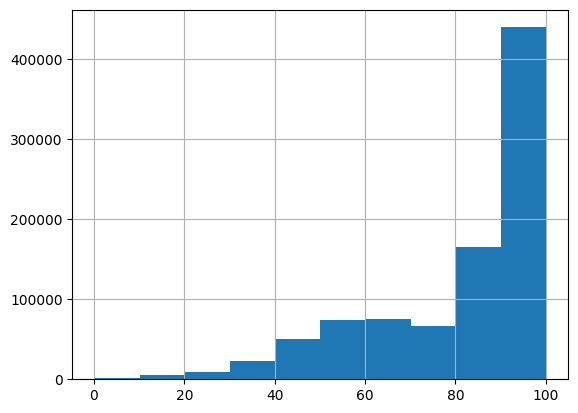

In [ ]:
df1['EAL_SCORE'].hist()

In [ ]:
df1.groupby('Zero Balance Code')['EAL_SCORE'].mean()

Zero Balance Code
2    83.615117
3    88.277221
9    78.415333
Name: EAL_SCORE, dtype: float64

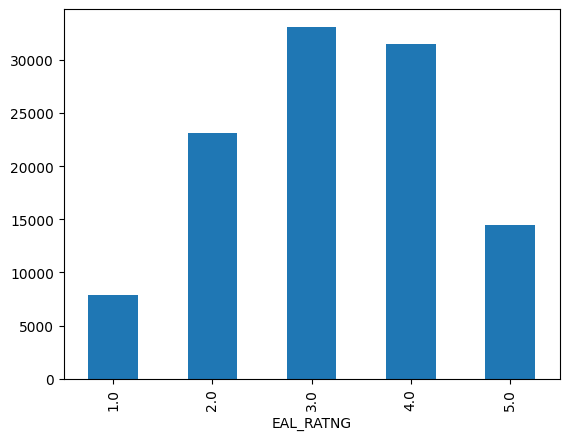

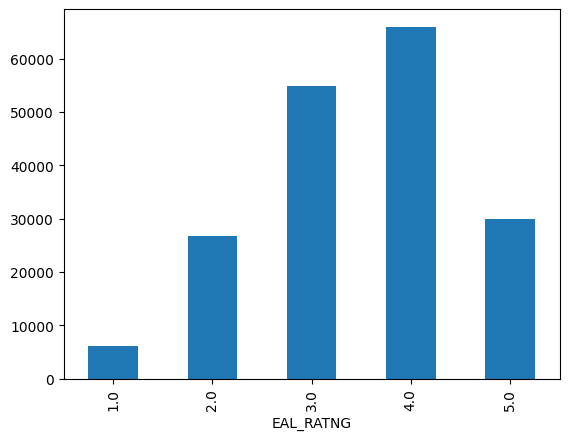

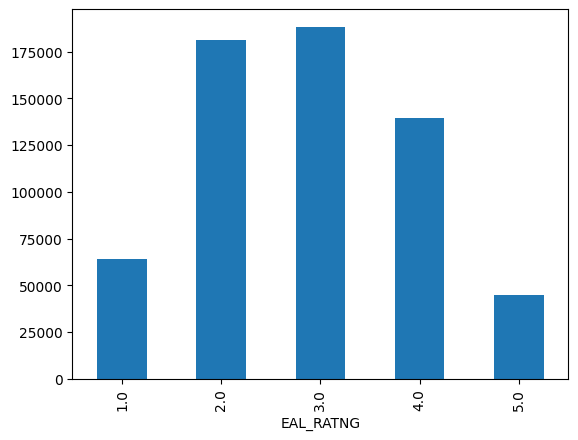

In [ ]:
for i in [2,3,9]:
  df1.groupby(['Zero Balance Code','EAL_RATNG'])['Loss Rate'].count()[i].plot(kind='bar')
  plt.show()

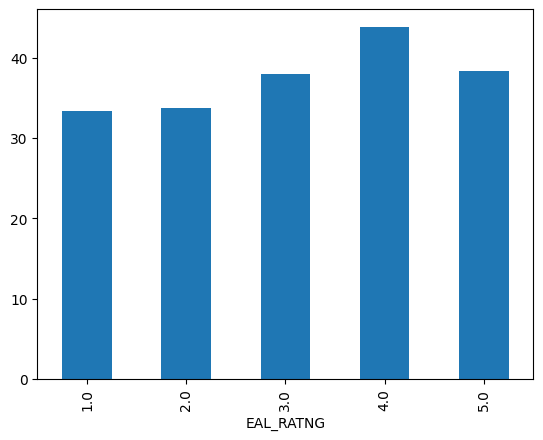

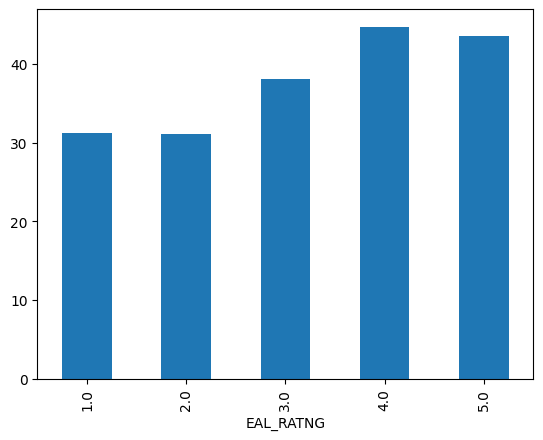

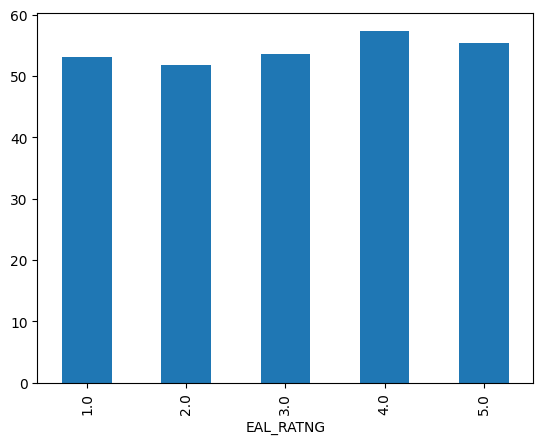

In [ ]:
for i in [2,3,9]:
  df1.groupby(['Zero Balance Code','EAL_RATNG'])['Loss Rate'].mean()[i].plot(kind='bar')
  plt.show()

In [ ]:
df1.groupby(['Zero Balance Code','EAL_RATNG'])['Loss Rate'].mean()

Zero Balance Code  EAL_RATNG
2                  1.0          33.383771
                   2.0          33.803998
                   3.0          38.028253
                   4.0          43.884576
                   5.0          38.307526
3                  1.0          31.201639
                   2.0          31.150154
                   3.0          38.021035
                   4.0          44.717261
                   5.0          43.506648
9                  1.0          53.102067
                   2.0          51.811818
                   3.0          53.553719
                   4.0          57.381422
                   5.0          55.450374
Name: Loss Rate, dtype: float64

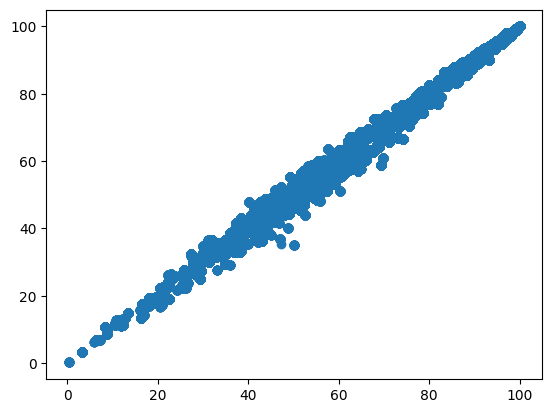

In [ ]:
plt.scatter(df1['RISK_SCORE'],df1['EAL_SCORE'])

In [ ]:
df1[['Loss Rate','EAL_SCORE']].describe()

,Loss Rate,EAL_SCORE
count,911346.000000,911346.000000
mean,49.330312,81.029664
std,32.207288,19.660929
min,0.049649,0.201176
25%,24.549522,68.842568
50%,45.948895,89.696227
75%,69.574559,96.414939
max,186.949087,100.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7dc39e7c3100>,
 'caps': [<matplotlib.lines.Line2D at 0x7dc39e7c3640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7dc39e7c2e30>],
 'medians': [<matplotlib.lines.Line2D at 0x7dc39e7c3b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7dc39e7c3e20>],
 'means': []}

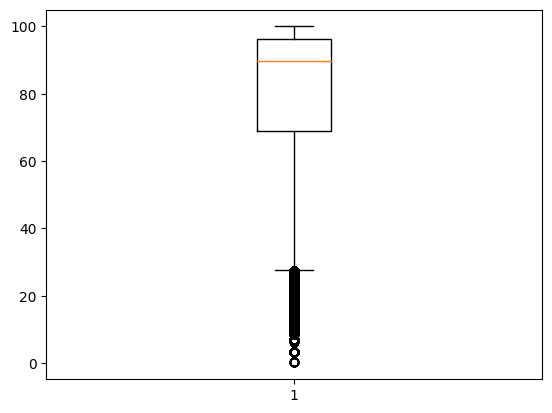

In [ ]:
plt.boxplot(df1['EAL_SCORE'])

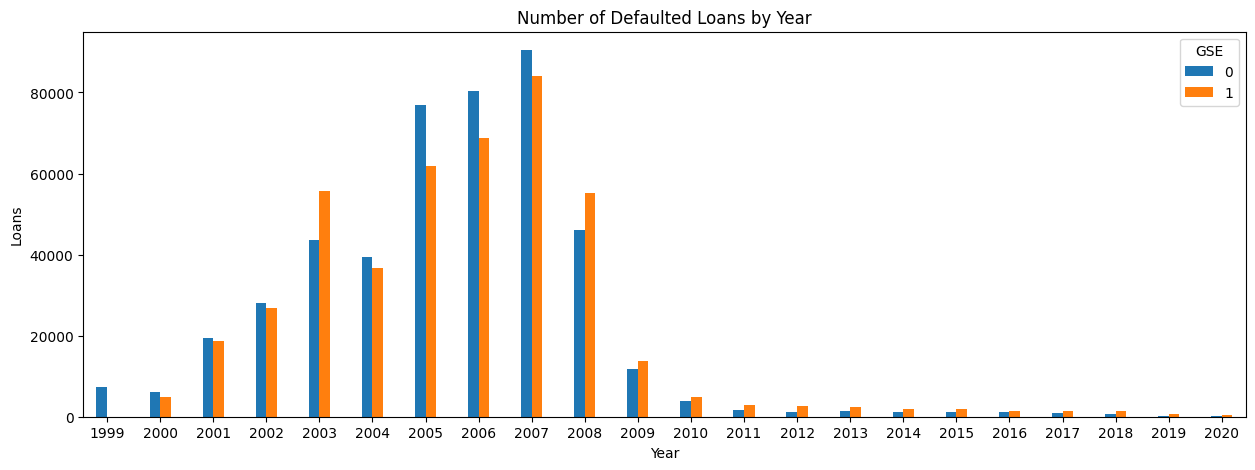

In [ ]:
grouped = df1.groupby(['orig_year','GSE']).size().unstack(fill_value=0)

# Calculating the total count of each GSE value across all Zero Balance Codes
total_counts = grouped.sum(axis=0)

# Calculating the percentage for each GSE value based on the total count of each GSE value
grouped_percentage = grouped.div(total_counts, axis=1) * 100
# Plotting the bar graph
ax = grouped.plot(kind='bar', width=0.4,figsize=(15, 5))
# Customizing the plot
plt.xlabel('Year')
plt.ylabel('Loans')
plt.title('Number of Defaulted Loans by Year')
plt.legend(title='GSE')

# Adjusting x-axis tick labels
ax.set_xticklabels(grouped.index, rotation=0)

# Adding percentage labels to the bars
#for container in ax.containers:
#    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

plt.show()

In [ ]:
grouped = df1.groupby(['orig_year','GSE']).size().unstack(fill_value=0)

# Calculating the total count of each GSE value across all Zero Balance Codes
total_counts = grouped.sum(axis=0)

# Calculating the percentage for each GSE value based on the total count of each GSE value
grouped_percentage = grouped.div(total_counts, axis=1) * 100
# Plotting the bar graph
ax = grouped.loc[2011:,:].plot(kind='bar', width=0.4,figsize=(15, 5))
# Customizing the plot
plt.xlabel('Year')
plt.ylabel('Loans')
plt.title('Number of Defaulted Loans by Year')
plt.legend(title='GSE')

# Adjusting x-axis tick labels
ax.set_xticklabels(grouped.index, rotation=0)

# Adding percentage labels to the bars
#for container in ax.containers:
#    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

plt.show()

GSE,0,1
orig_year,,
2011,1669,2911
2012,1211,2533
2013,1336,2506
2014,1254,1896
2015,1143,1796
2016,1077,1513
2017,910,1534
2018,620,1402
2019,294,672


In [ ]:
df1.count()

Loan Sequence Number                                            911346
Modification Flag                                                63405
Metropolitan Statistical Area (MSA) Or Metropolitan Division    911346
loan_age                                                        911346
Prepayment Penalty Mortgage (PPM) Flag                          911344
                                                                 ...  
cltv_current2                                                   911346
cltv_current3                                                   911346
fico1                                                           911346
fico2                                                           911346
fico3                                                           911346
Length: 243, dtype: int64

In [ ]:
df['buckets']=df[['Normal','Boom','Bust','PostCrisis']].idxmax(axis=1)

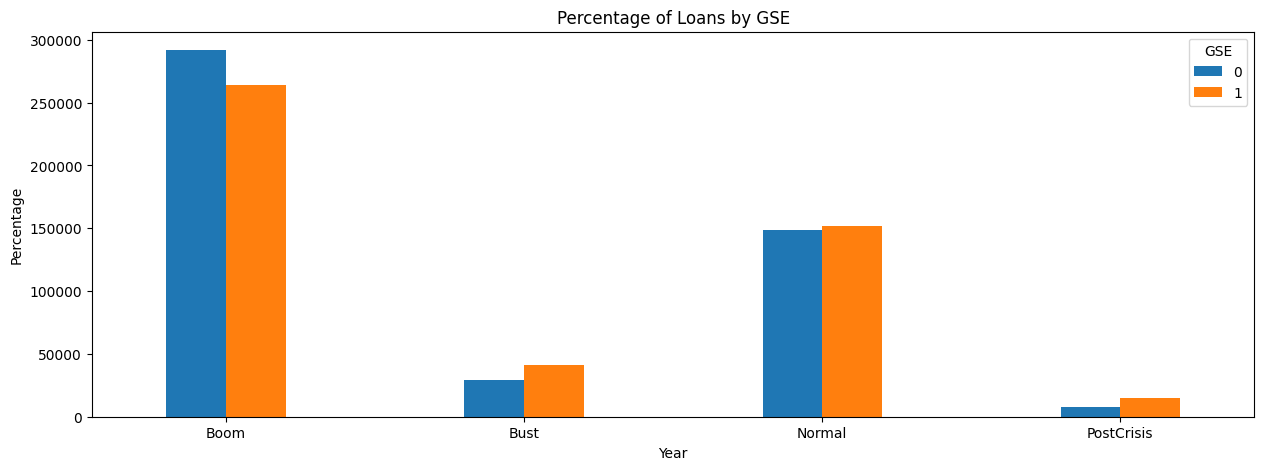

In [ ]:
grouped = df.groupby(['buckets','GSE']).size().unstack(fill_value=0)

# Calculating the total count of each GSE value across all Zero Balance Codes
total_counts = grouped.sum(axis=0)

# Calculating the percentage for each GSE value based on the total count of each GSE value
grouped_percentage = grouped.div(total_counts, axis=1) * 100
# Plotting the bar graph
ax = grouped.plot(kind='bar', width=0.4,figsize=(15, 5))
# Customizing the plot
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of Loans by GSE')
plt.legend(title='GSE')

# Adjusting x-axis tick labels
ax.set_xticklabels(grouped.index, rotation=0)

# Adding percentage labels to the bars
#for container in ax.containers:
#    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

plt.show()

In [ ]:
grouped = grouped.reindex(['Normal','Boom','Bust','PostCrisis'])

In [ ]:
(df.Normal+df.Boom+df.Bust+df.PostCrisis).sum()

950102

In [ ]:
df.groupby('buckets')['Loss Rate'].mean()

buckets
Boom          0.513915
Bust          0.442590
Normal        0.480419
PostCrisis    0.351519
Name: Loss Rate, dtype: float64

<Axes: xlabel='orig_year'>

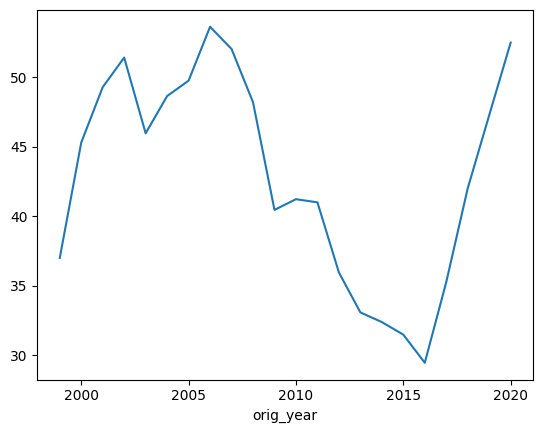

In [ ]:
df1.groupby('orig_year')['Loss Rate'].mean().plot()

In [ ]:
df1.groupby('orig_year')['Loss Rate'].mean()

orig_year
1999    37.003711
2000    45.303162
2001    49.290258
2002    51.420615
2003    45.969765
2004    48.650971
2005    49.759417
2006    53.634650
2007    52.039059
2008    48.206529
2009    40.461142
2010    41.231062
2011    41.004826
2012    35.962440
2013    33.087532
2014    32.392363
2015    31.487027
2016    29.463539
2017    35.267451
2018    42.015775
2019    47.275785
2020    52.497408
Name: Loss Rate, dtype: float64